In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from running import rw_directory
from model.myGraph import MyGraph
import random
from model.AMKS.amks import AMKS, MultiHopAMKS
from model.utils import get_mus_sigma

In [2]:
custom_style = {
    'axes.prop_cycle': plt.cycler('color', ['red', 'green', 'blue']),
    'lines.linewidth': 2,
    'font.size': 12,
    'font.family': 'times new roman',
    'axes.facecolor': 'w',
    'axes.edgecolor': 'black',
    'axes.titlesize': 20,
    'legend.fontsize': 12,
    'axes.labelsize': 20,
    'axes.linewidth':2,
    'xtick.labelsize':12,
    'ytick.labelsize':12
}
plt.style.use(custom_style)

In [3]:
def generate_N_graph(num_center_nodes=8, num_wheels=2):
    """构造部分图 G_N"""
    g = nx.wheel_graph(num_center_nodes)
    num_wheel_nodes = num_center_nodes - 1
    # 添加其余轮子图，轮子边上的点两两相连，不同轮子上相同位置上的点相连
    for wheel_idx in range(1, num_wheels):
        # 和老轮子相连
        for node_idx in range(1, num_center_nodes):
            g.add_node(num_wheel_nodes * wheel_idx + node_idx)
            g.add_edge(num_wheel_nodes * (wheel_idx - 1) + node_idx, num_wheel_nodes * wheel_idx + node_idx)
        # 新轮子各边相连
        for node_idx in range(1, num_wheel_nodes):
            g.add_edge(num_wheel_nodes * wheel_idx + node_idx, num_wheel_nodes * wheel_idx + node_idx + 1)
        g.add_edge(num_wheel_nodes * (wheel_idx + 1), num_wheel_nodes * wheel_idx + 1)
    # 最外圈的顶点
    out_center_nodes = [i for i in range(num_wheel_nodes * wheel_idx + 1, num_wheel_nodes * (wheel_idx + 1))]

    pos = nx.spectral_layout(g)
    nx.draw(g, pos=pos, node_color='darkred', with_labels=False, node_size=150, font_size=10)
    plt.savefig(rw_directory.result_path(3, 'Graph_N.pdf'), pad_inches=0, bbox_inches='tight')
    with open(rw_directory.temp_file_path(3, 'Graph_N.edgelist'), 'wb') as f1:
        nx.write_edgelist(g, f1)
    f1.close()
    return g, out_center_nodes




(<networkx.classes.graph.Graph at 0x7fe6bc7f3b80>, [8, 9, 10, 11, 12, 13])

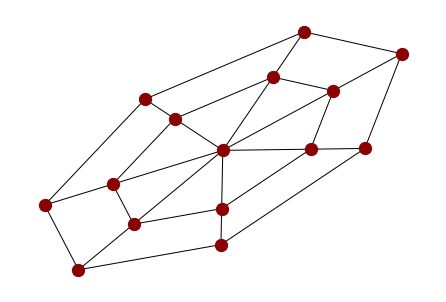

In [4]:
generate_N_graph(8, 2)

In [5]:
def generate_M_graph(random_node=40, random_edge=80, connect_edge=3, seed=123):
    generated_subgraph, out_center_nodes = generate_N_graph()

    generated_subgraph_num = len(generated_subgraph.nodes)
    G = MyGraph(generated_subgraph)
    random_graph = nx.gnm_random_graph(random_node, random_edge, seed=seed)  # n节点 m边
    # 重新为节点标号
    random_graph_mapping = {i: i + generated_subgraph_num for i in random_graph.nodes}
    nx.relabel_nodes(random_graph, random_graph_mapping, copy=False)  # copy= False 表示直接在原图上改动

    G.add_nodes_from(random_graph.nodes)

    G.add_edges_from(random_graph.edges)

    M_connect_nodes = [i for i in random_graph.nodes]

    # 随机将子图外围节点与原图节点连接
    for i in range(connect_edge):
        node = random.choice(out_center_nodes)
        neighbor = random.choice(M_connect_nodes)
        G.add_edge(node, neighbor)

    pos1 = nx.spectral_layout(generated_subgraph)
    pos = nx.spring_layout(G)

    # 使得绘图时车轮图和其余顶点分开
    for node in G.nodes:
        if node in generated_subgraph:
            pos[node] = pos1[node]
        else:
            pos[node] = pos[node] * 3 + 3

    node_colors = ['darkred' if i in generated_subgraph else 'navy' for i in G.nodes()]  # 节点颜色
    plt.figure(figsize=(20, 15))
    nx.draw(G, pos=pos, node_color=node_colors, with_labels=False)
    plt.savefig(rw_directory.result_path(3, 'Graph_M.pdf'), pad_inches=0, bbox_inches='tight')
    plt.show()

    with open(rw_directory.temp_file_path(3, 'Graph_M.edgelist'), "wb") as f1:
        nx.write_edgelist(G, f1)
    f1.close()

    return G, pos

In [6]:
# generate_M_graph()

In [7]:
def generate_MN_graph(M_graph, sub_N_graph, out_center_nodes, M_pos, connect_edge=3):
    Mgraph_nodes_num = len(M_graph.nodes)
    Ngraph_nodes_num = len(sub_N_graph.nodes)
    N_graph_mapping = {i: i + Mgraph_nodes_num for i in sub_N_graph.nodes}

    out_center_nodes = [i + Mgraph_nodes_num for i in out_center_nodes]
    N_graph = nx.relabel_nodes(sub_N_graph, N_graph_mapping, copy=True)  # 改变标签后的N图

    posN = nx.spectral_layout(N_graph)
    new_posN = {node: (posN[node][0], posN[node][1] + 5) for node in posN}
    posM = M_pos

    G = MyGraph(M_graph)
    G.add_nodes_from(N_graph.nodes)
    G.add_edges_from(N_graph.edges)

    N_connect_nodes = out_center_nodes[-connect_edge:]
    m = M_graph.nodes
    M_connect_nodes = [i for i in sorted(M_graph.nodes)][Ngraph_nodes_num - Mgraph_nodes_num:]
    for i in N_connect_nodes:
        neighbor = random.choice(M_connect_nodes)
        G.add_edge(i, neighbor)

    pos = {}
    pos1 = nx.spectral_layout(N_graph)  # 调整布局,保留子图部分布局不变
    for node in G.nodes():
        if node in range(Mgraph_nodes_num):
            pos[node] = posM[node]
        else:
            pos[node] = new_posN[node]

    node_colors = ['yellow' if i in N_graph else 'navy' for i in G.nodes()]  # 节点颜色
    node_colors[:Ngraph_nodes_num] = ['darkred' for i in range(Ngraph_nodes_num)]
    plt.figure(figsize=(20, 20))

    nx.draw(G, pos=pos, node_color=node_colors, with_labels=False)

    fname = rw_directory.result_path(3, 'Graph_MN.pdf')
    plt.savefig(fname, pad_inches=0, bbox_inches='tight')
    plt.show()

    fname = rw_directory.temp_file_path(3, 'Graph_MN.edgelist')
    with open(fname, "wb") as f1:
        nx.write_edgelist(G, f1)
    f1.close()

    return G

In [8]:
def compute_vec(g, time=0.2, amks_variance=0.8, step=10):
    completeM_model = AMKS()  # (Em,M)
    completeM_model.set_time(time)
    completeM_model.set_g(g)
    completeM_model.set_sigma(amks_variance)
    completeM_model.set_step(step)
    completeM_model.compute_emb_vec()

    completeM_vecs = completeM_model.get_embedding_vec(sorted(g.nodes))
    mus, sigma = get_mus_sigma(g, amks_variance, step)
    return completeM_vecs, mus, sigma

In [9]:
def polt_M_N(mus, M_mus, N_mus, completeMN_vecs, completeM_vecs, completeN_vecs, index, compare_index,):  # 分开画嵌入曲线
    plt.xlabel('Element index')
    plt.ylabel('Element value')
    plt.rcParams["axes.unicode_minus"] = False
    plt.plot(M_mus, completeM_vecs[index], c='forestgreen', label="(Em,M)")
    plt.plot(N_mus, completeN_vecs[index], 'palevioletred', label="(En,N)")
    plt.legend(loc='best')
    plt.title(f"node {index} embedding vector in graph M and N")
    save_name = rw_directory.result_path(3, f"node_{index}_M_N_isolate.pdf")
    plt.savefig(save_name, bbox_inches='tight', pad_inches=0.2)
    plt.show()

    plt.xlabel('Element index')
    plt.ylabel('Element value')
    plt.plot(mus, completeMN_vecs[index], linestyle='--', c='darkorange', label="node " + str(index) + " (Emn,MN)")
    plt.plot(mus, completeMN_vecs[compare_index], c='dodgerblue',linestyle='--', label="node " + str(compare_index) + "(Emn,MN)")
    plt.legend(loc='best')
    plt.title(f"node {index}/{compare_index} embedding vector in graph MN")
    save_name = rw_directory.result_path(3, f"node_{index}_M_N_combine.pdf")
    plt.savefig(save_name, bbox_inches='tight', pad_inches=0.2)
    plt.show()

In [10]:
def test_nx_graph2(time=0.2, amks_variance=0.8, step=100, index_list=None):
    if index_list is None:
        index_list = [0, 2, 4, 6]
    random_node = 40
    random_edge = 80
    connect_edge = 3
    tag_name = "random_node_" + str(random_node) + "_random_edge_" + str(random_edge) + "_connect_edge_" + str(
        connect_edge)

    N_graph, out_center_nodes = generate_N_graph()
    N_graph = MyGraph(N_graph)
    N_graph.set_graph_tag("wheel_N")
    M_graph, M_pos = generate_M_graph(random_node=random_node, random_edge=random_edge, connect_edge=connect_edge)
    M_graph.set_graph_tag(tag_name)
    MN_graph = generate_MN_graph(M_graph, N_graph, out_center_nodes, M_pos, connect_edge=connect_edge)

    MN_graph.set_graph_tag("MN" + tag_name)
    index = 6

    completeM_vecs, M_mus, M_sigma = compute_vec(M_graph, step=step)
    completeN_vecs, N_mus, N_sigma = compute_vec(N_graph, step=step)
    completeMN_vecs, mus, MN_sigma = compute_vec(MN_graph, step=step)

    fname = rw_directory.result_path(3, 'm_graph.edgelist')
    with open(fname, "wb") as f1:
        nx.write_edgelist(M_graph, f1)
    fname = rw_directory.temp_file_path(3, 'n_graph.edgelist')
    with open(fname, "wb") as f2:
        nx.write_edgelist(N_graph, f2)
    fname = rw_directory.result_path(3, 'mn_graph.edgelist')
    with open(fname, "wb") as f3:
        nx.write_edgelist(MN_graph, f3)

    # draw_M_N(M_graph, N_graph, M_pos)
    M_nodesNum = len(M_graph.nodes)

    for index in index_list:
        polt_M_N(mus, M_mus, N_mus, completeMN_vecs, completeM_vecs, completeN_vecs, index,
                 compare_index=index + M_nodesNum)



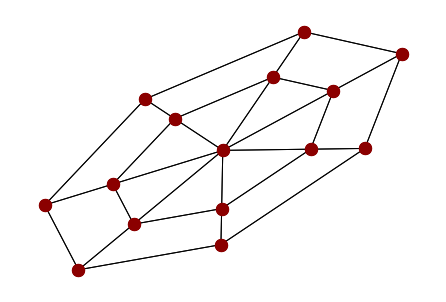

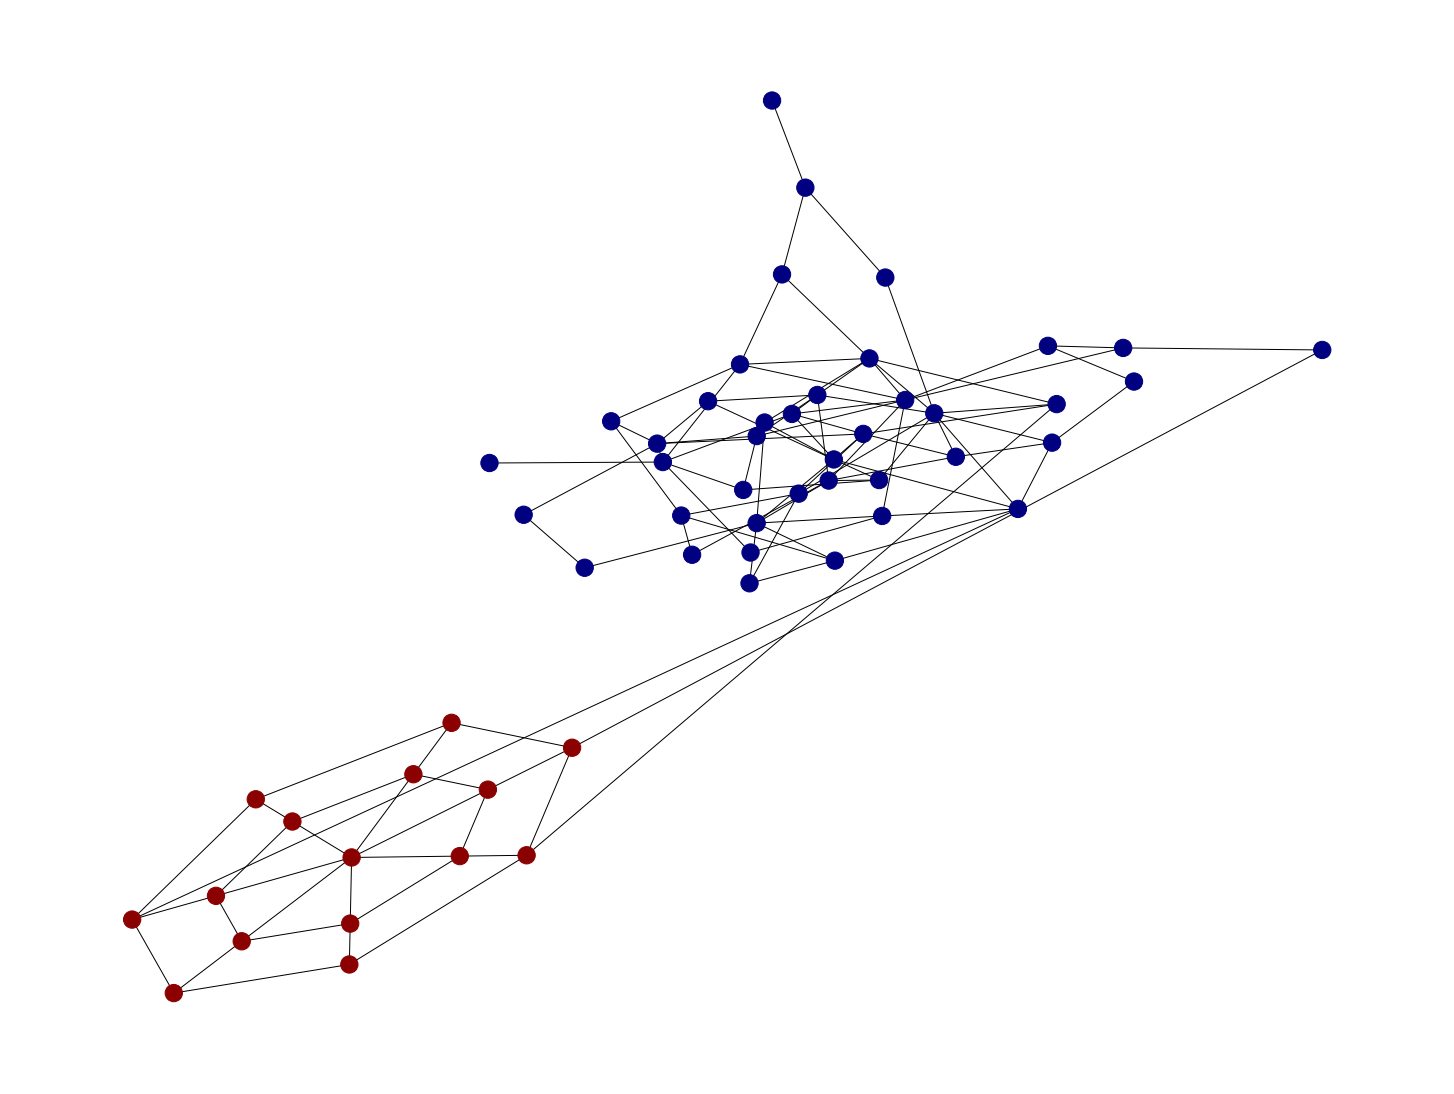

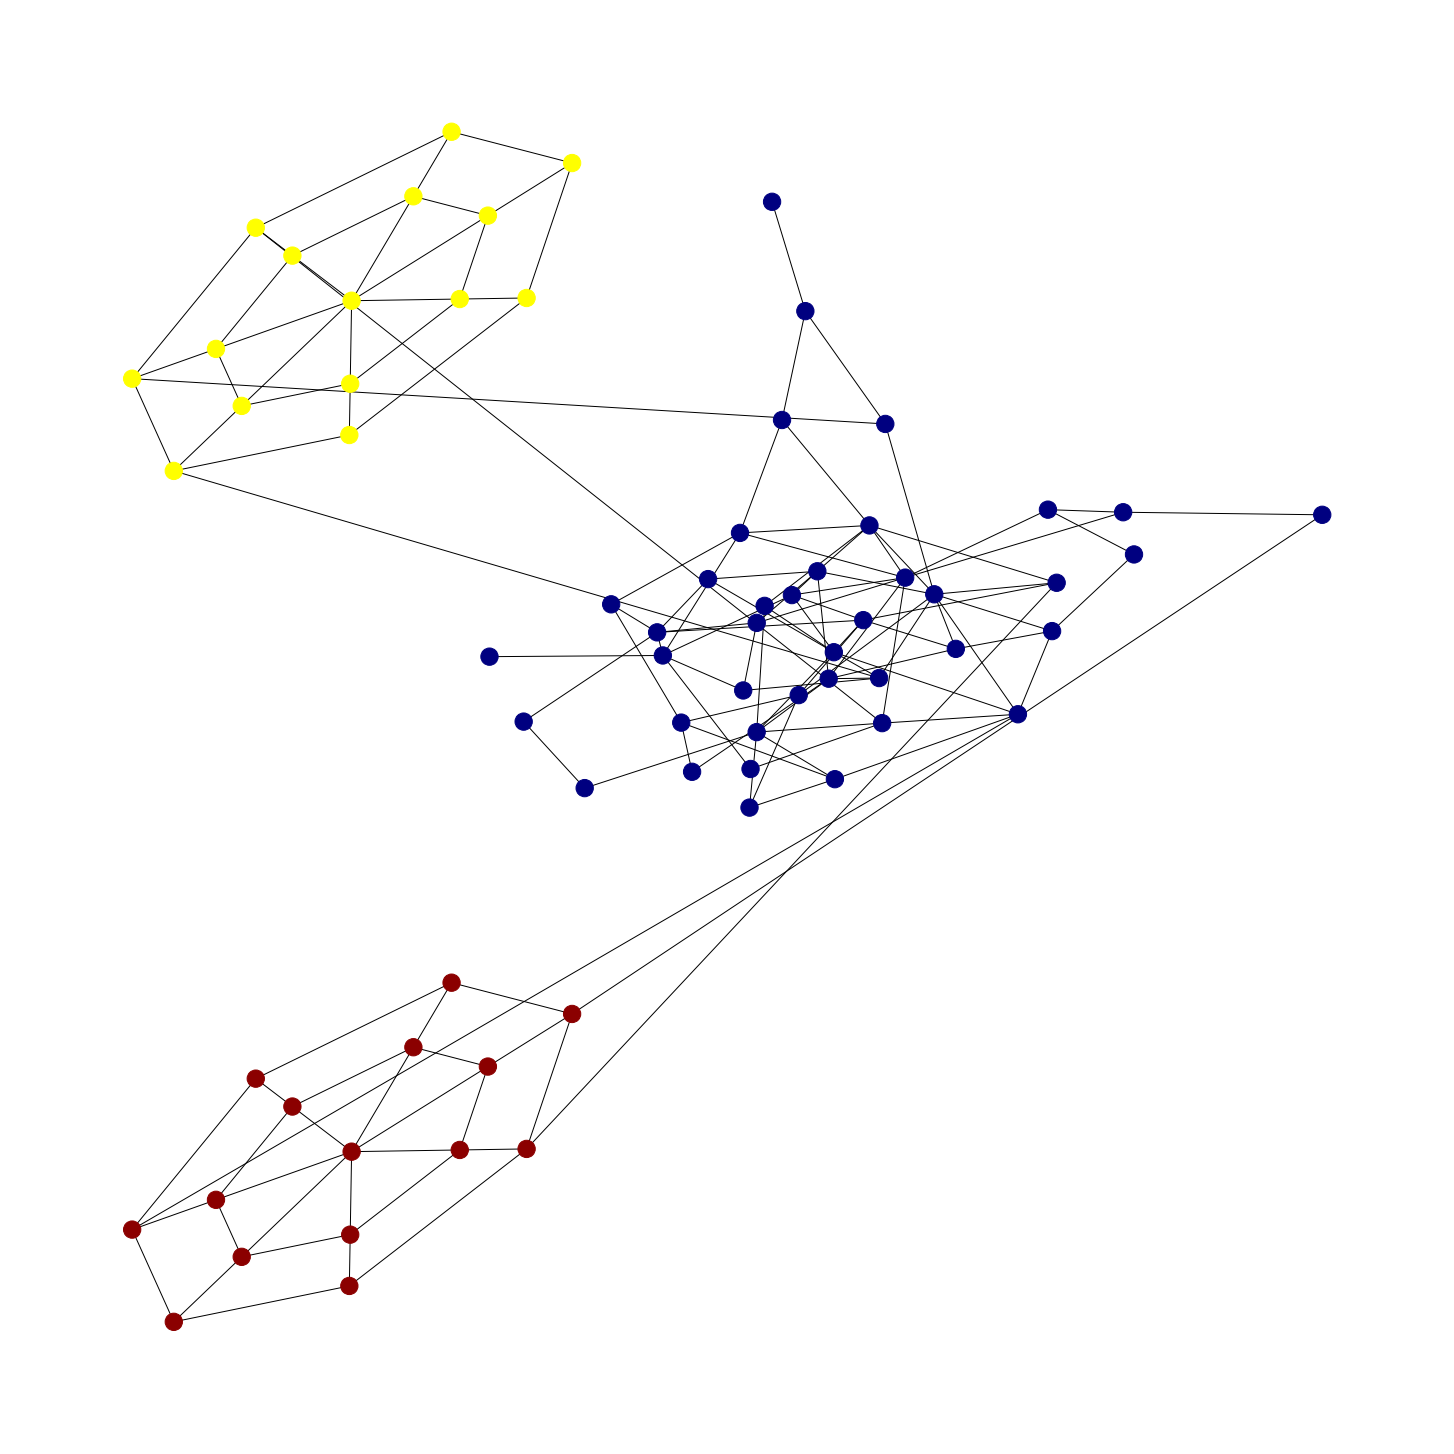

/home/zjh/project2/Graph_Embedding_Ex1/src/model/utils.py:40: RuntimeWarning: invalid value encountered in true_divide
  F = F1 * F2 / temp


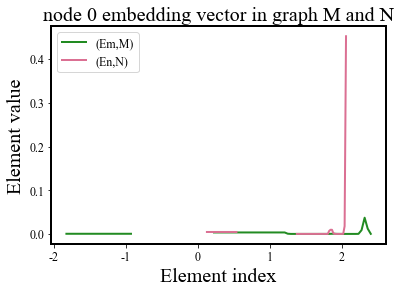

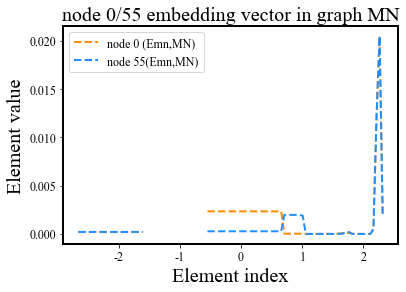

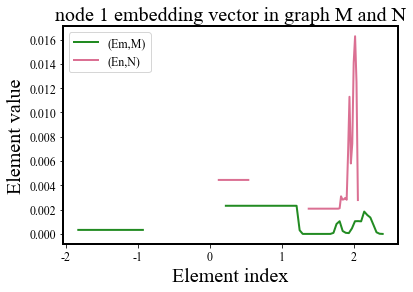

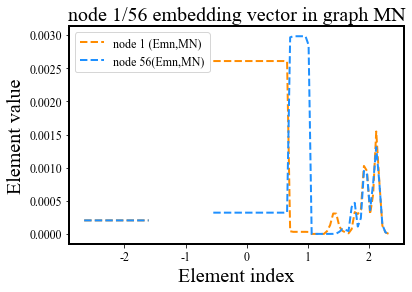

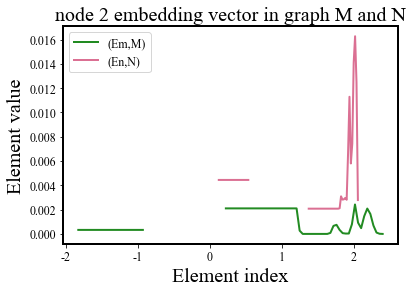

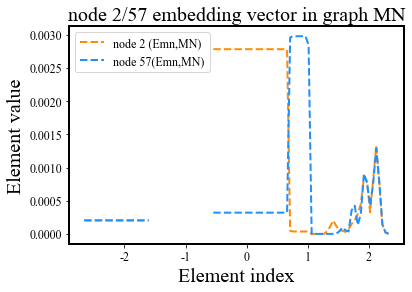

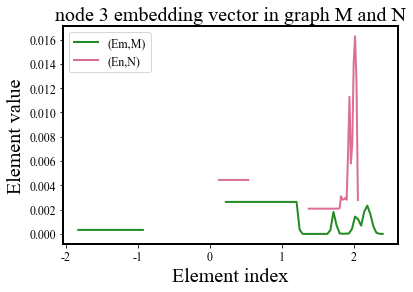

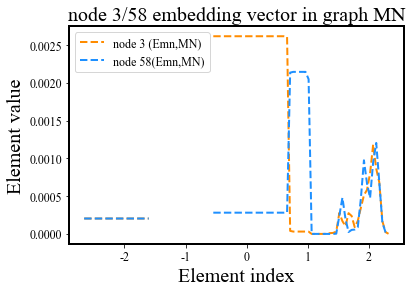

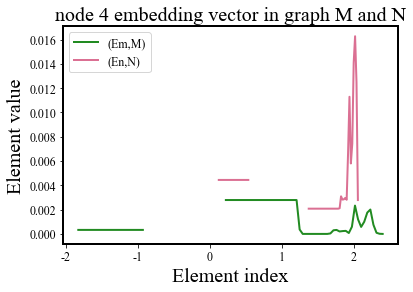

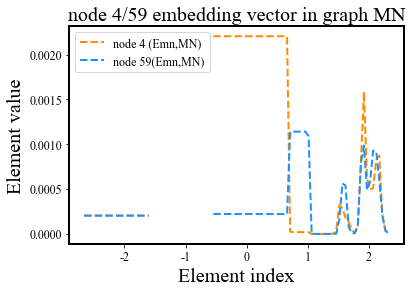

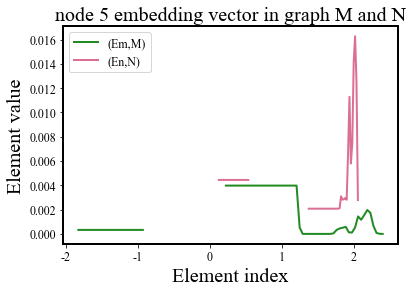

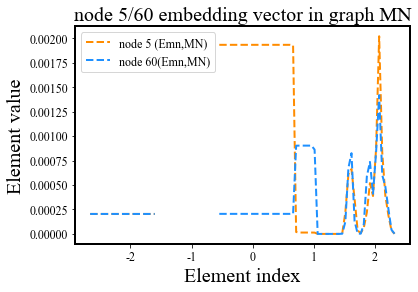

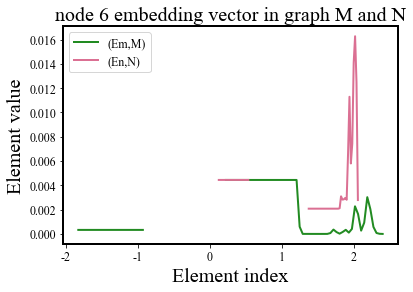

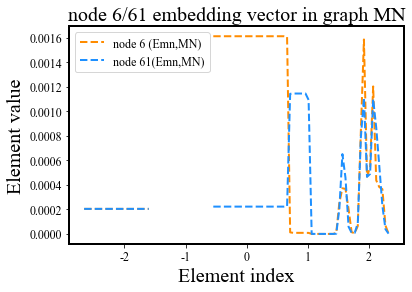

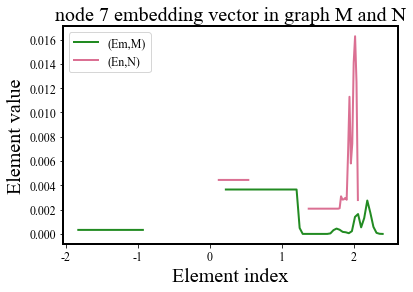

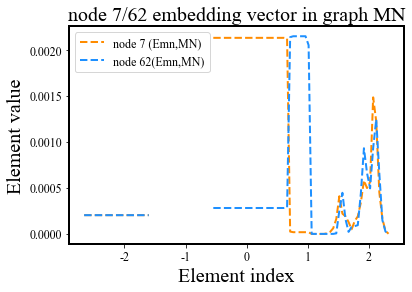

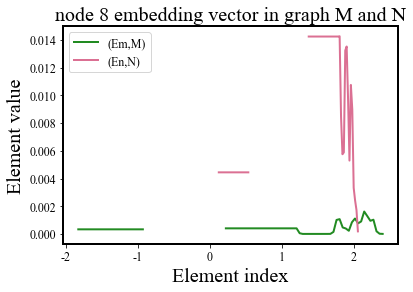

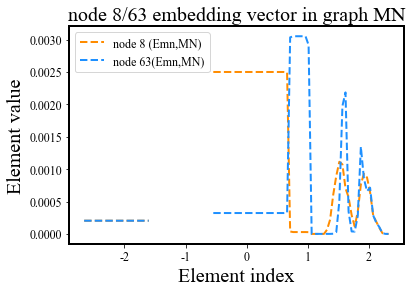

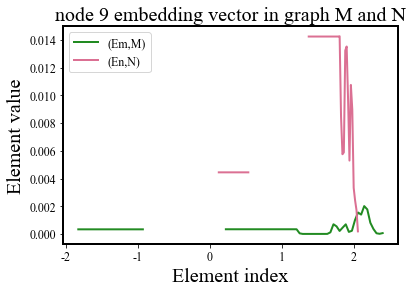

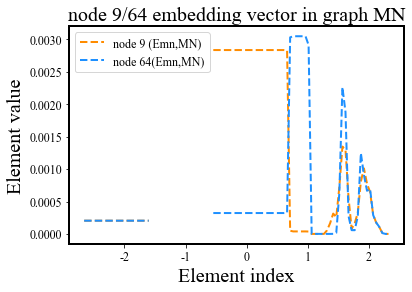

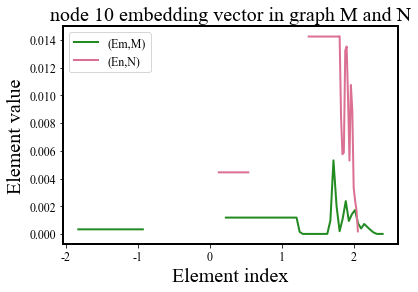

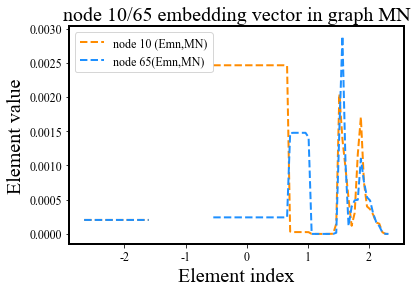

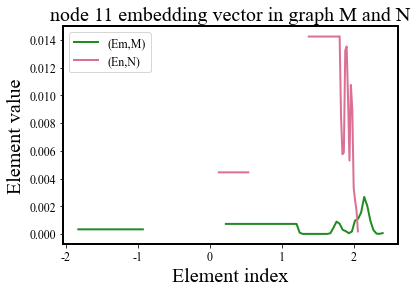

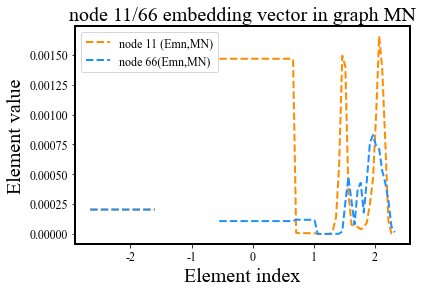

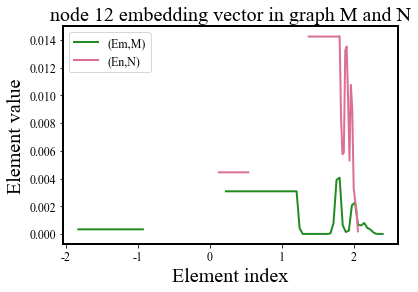

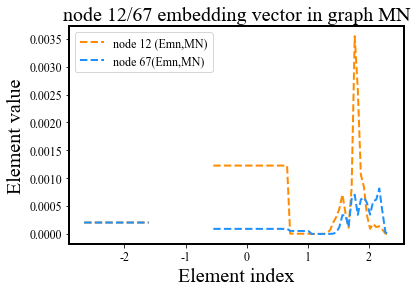

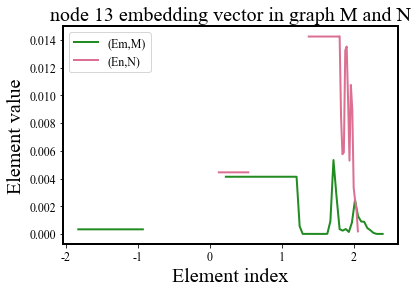

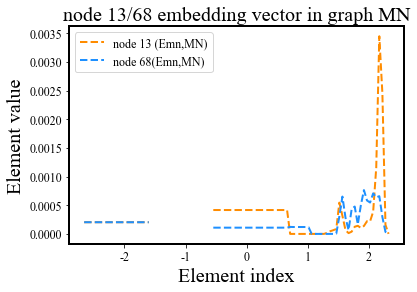

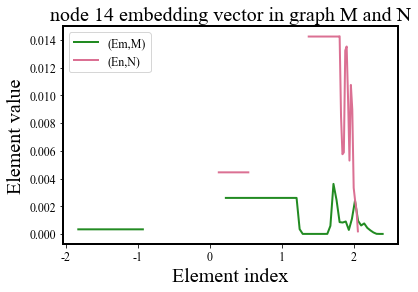

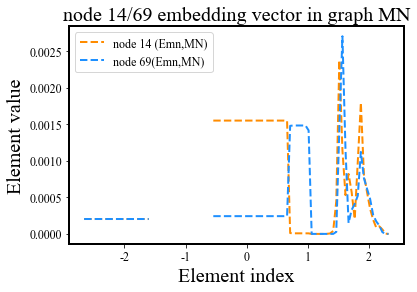

In [11]:
node_indices = list(range(15))
test_nx_graph2(index_list=node_indices)